# PINNs

## Simple diffusion equation
The first thing we can use PINNs to do is to try to solve the simple, static 1-D diffusion (or Laplace) equation
$$ 
\frac{\partial^2 u}{\partial x^2} = f,\; x\in[0,1]
$$
subject to Dirichlet boundary conditions
$$
u(x=0) = 0, \; u(x=1) = 0.
$$
First, we import torch






In [4]:
import torch

Next, we need to define a neural network to act as an ansatz solution operator - in particular, we're going to assume that the solution to the PDE $u(x) \equiv NN_\theta(x)$.  This is a simple PDE, so we can use a pretty simple network.

In [6]:
class LaplacePINN(torch.nn.Module):
    def __init__(self,d=1,h=11):
        super(LaplacePINN, self).__init__()
        self.l_1 = torch.nn.Linear(d,h)
        self.l_2 = torch.nn.Linear(h,1)
        
    def forward(self,x):
        a_1 = self.l_1(x)
        z_1 = torch.tanh(a_1)
        return self.l_2(z_1)

net = LaplacePINN()

We can test this function by applying it to some points.  

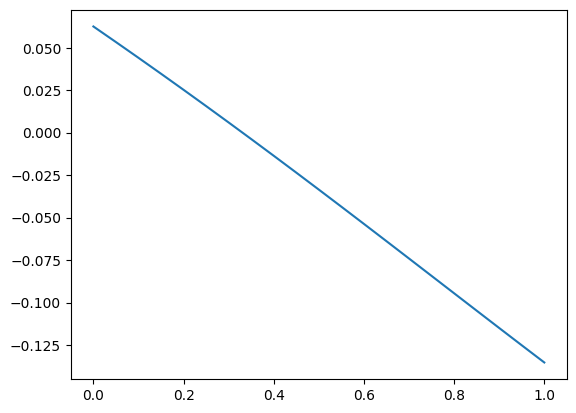

In [7]:
import matplotlib.pyplot as plt
x = torch.linspace(0,1,21,requires_grad=True).reshape(-1,1)
u_test = net(x)
plt.plot(x.detach().squeeze(),u_test.detach().squeeze())

We need to train this network to get it to produce something useful.  Our training objective will be the squared norm of the residual plus the boundary conditions
$$
L(\theta) = \sum_{i=1}^{N_c} \left[ k\frac{\partial^2 u(x_i)}{\partial x^2} - f\right]^2 + u(x=0)^2 + u(x=1)^2,
$$
where the sum is over some collocation points.  To evaluate this, we need access to the gradients of the network outputs with respect to the inputs (actually the second derivatives).  We can build a function that provides all three.


In [9]:
def get_grad_and_hessian(net,x):
    u = net(x)
    du = torch.autograd.grad(u,x,torch.ones_like(x),create_graph=True)[0]
    d2u = torch.autograd.grad(du,x,torch.ones_like(x),create_graph=True)[0]
    return u,du,d2u

u,dudx,d2udx2 = get_grad_and_hessian(net,x)
print(u)
print(dudx)

tensor([[-0.2820],
        [-0.2860],
        [-0.2899],
        [-0.2937],
        [-0.2976],
        [-0.3014],
        [-0.3053],
        [-0.3092],
        [-0.3131],
        [-0.3172],
        [-0.3213],
        [-0.3255],
        [-0.3299],
        [-0.3344],
        [-0.3390],
        [-0.3438],
        [-0.3488],
        [-0.3539],
        [-0.3591],
        [-0.3644],
        [-0.3699]], grad_fn=<AddmmBackward0>)
tensor([[-0.0800],
        [-0.0787],
        [-0.0777],
        [-0.0771],
        [-0.0768],
        [-0.0769],
        [-0.0774],
        [-0.0784],
        [-0.0797],
        [-0.0815],
        [-0.0836],
        [-0.0860],
        [-0.0886],
        [-0.0915],
        [-0.0945],
        [-0.0975],
        [-0.1004],
        [-0.1032],
        [-0.1057],
        [-0.1079],
        [-0.1097]], grad_fn=<MmBackward0>)


Now it's straightforward to use these to train the network using typical pytorch routines.

In [21]:
# Diffusivity
k = torch.tensor([1.0],requires_grad=True)

# Left and right boundary value
u0 = 0
u1 = 0

u_obs = 1.0
x_obs = 0.5

# Re-initialize
net = LaplacePINN()
# 
n_epochs = 1000
n_colloc = 10
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)
optimizer_2 = torch.optim.Adam([k],lr=1e-2)
for i in range(n_epochs):
    optimizer.zero_grad()
    optimizer_2.zero_grad()

    x_c = torch.rand(n_colloc,1,requires_grad=True)

    # Forcing function
    f = torch.zeros_like(x_c)
    f[:] = 1.
    u,dudx,d2udx2 = get_grad_and_hessian(net,x_c)


    I_eqn = torch.mean((k*d2udx2 - f)**2)

    u_left = net(torch.tensor([[0.0]]))
    u_right = net(torch.tensor([[1.0]]))

    I_bnd = (u_left - u0)**2 + (u_right - u1)**2

    I_data = (net(torch.tensor([[x_obs]])) - u_obs)**2
    
    I = I_eqn + I_bnd + I_data
    
    I.backward()
    optimizer.step()
    optimizer_2.step()
    print(I_eqn.item(),I_bnd.item(),I_data.item())


0.930203914642334 0.16017530858516693 0.9379190802574158
1.0296823978424072 0.1667322963476181 0.8179521560668945
0.9319194555282593 0.18096882104873657 0.722080409526825
0.8775368928909302 0.19414173066616058 0.6559849977493286
0.9172525405883789 0.20904448628425598 0.6048462986946106
0.8932253122329712 0.22385388612747192 0.5644313097000122
0.8075257539749146 0.23734450340270996 0.5331114530563354
0.7786185145378113 0.2490580677986145 0.5097667574882507
0.6456699967384338 0.25781920552253723 0.49333950877189636
0.7146714925765991 0.26421862840652466 0.48279768228530884
0.6257734298706055 0.266353577375412 0.4780028760433197
0.6014025211334229 0.2645939886569977 0.47836583852767944
0.6842448115348816 0.2592398524284363 0.4832928776741028
0.5413784384727478 0.24997995793819427 0.49222075939178467
0.474778950214386 0.2385159283876419 0.5043280124664307
0.4399779438972473 0.22604919970035553 0.5188060998916626
0.4341990053653717 0.21322496235370636 0.5347579121589661
0.4001258313655853 0

0.032271504402160645 2.8432491490093525e-06
0.0203283429145813 1.3355336250242544e-06
0.030662596225738525 2.4400713982686284e-07
0.02027451992034912 5.168916459297179e-07
0.020738720893859863 8.831344189275114e-08
0.024216651916503906 1.607766989764059e-06
0.019465208053588867 7.925296472421905e-07
0.024716317653656006 3.610802536968549e-07
0.022188842296600342 3.581267264962662e-06
0.01929175853729248 2.087401071548811e-06
0.029162466526031494 7.34742684471712e-08
0.026679813861846924 2.48208743869327e-06
0.019958913326263428 7.142567426399182e-08
0.019289851188659668 5.358130650279236e-08
0.020513951778411865 2.4981835622384096e-07
0.018904268741607666 5.2418329232750693e-08
0.020190954208374023 3.549843796690766e-08
0.01915830373764038 5.134337754952867e-08
0.019788265228271484 1.258314625829371e-07
0.020273208618164062 1.1531898280736641e-07
0.019103407859802246 3.393073200186336e-07
0.019170522689819336 6.386070481312345e-07
0.01931697130203247 4.5647948354599066e-07
0.0206291675

0.054107487201690674 2.321589272469282e-05
0.09722208976745605 1.6350588339264505e-05
0.13573455810546875 2.8413351174094714e-05
0.0722876787185669 1.5291352610802278e-05
0.08201837539672852 2.3003476599114947e-05
0.12378060817718506 3.305237623862922e-05
0.06492793560028076 1.539475124445744e-05
0.08507370948791504 2.8416443456080742e-05
0.12279236316680908 4.421535777510144e-05
0.060185253620147705 2.241699257865548e-05
0.08670276403427124 1.762626379786525e-05
0.12116897106170654 2.6215320758637972e-05
0.05603295564651489 1.2986869478481822e-05
0.0994335412979126 2.7718742785509676e-05
0.14229559898376465 3.987407035310753e-05
0.08332645893096924 1.750974843162112e-05
0.06645840406417847 2.0331684936536476e-05
0.10467982292175293 3.493254553177394e-05
0.04310327768325806 1.751349918777123e-05
0.10893118381500244 1.6860545656527393e-05
0.14893341064453125 2.6736031941254623e-05
0.08766353130340576 1.2532609616755508e-05
0.06389492750167847 2.3753071218379773e-05
0.10398226976394653 3

0.018253564834594727 1.1256796824454796e-05
0.01849418878555298 1.1267280569882132e-05
0.01808035373687744 1.1691475265251938e-05
0.018121838569641113 1.1867550711031072e-05
0.01809769868850708 1.2083238289051224e-05
0.018204450607299805 1.2331156540312804e-05
0.018322765827178955 1.2371366210572887e-05
0.018079161643981934 1.2178630640846677e-05
0.018819987773895264 1.2055759725626558e-05
0.018355488777160645 1.1392917258490343e-05
0.02106451988220215 1.1253199772909284e-05
0.02199685573577881 9.781824701349251e-06
0.025931596755981445 1.002603858069051e-05
0.023879647254943848 9.902620149659924e-06
0.024158179759979248 9.496547136222944e-06
0.017956852912902832 1.0288265002600383e-05
0.02978336811065674 1.3324306564754806e-05
0.031527042388916016 9.593781214789487e-06
0.02159583568572998 1.2688486094702967e-05
0.020987331867218018 1.1628592801571358e-05
0.030059635639190674 7.396366527245846e-06
0.03173929452896118 9.732516446092632e-06
0.0181729793548584 5.825550942972768e-06
0.0296

0.018942594528198242 3.349409098518663e-06
0.02053922414779663 4.073482159583364e-06
0.025197625160217285 3.357077730470337e-06
0.025536298751831055 4.055605131725315e-06
0.01950019598007202 2.714900801947806e-06
0.02005612850189209 2.3559798592032166e-06
0.024338901042938232 2.1330820345610846e-06
0.01948326826095581 3.563048949217773e-06
0.021958768367767334 5.400087502493989e-06
0.03031402826309204 5.877436706214212e-06
0.019713521003723145 6.776785085094161e-06
0.029058992862701416 7.509904207836371e-06
0.03609222173690796 7.4062722887902055e-06
0.01895838975906372 6.049841886124341e-06
0.02964615821838379 6.146327905298676e-06
0.03238677978515625 5.502810381585732e-06
0.019344627857208252 4.206023277220083e-06
0.022923588752746582 4.00805856770603e-06
0.04498887062072754 4.555421583063435e-06
0.01841825246810913 2.547294116084231e-06
0.042845964431762695 6.1665900830121245e-06
0.01949596405029297 2.842598860297585e-06
0.045026540756225586 3.157016180921346e-06
0.018022000789642334

0.01880180835723877 1.0551506193223759e-06
0.05083191394805908 3.391743121028412e-06
0.019819259643554688 1.00630325050588e-06
0.06043285131454468 9.123328709392808e-06
0.02919548749923706 4.02048317482695e-06
0.08464312553405762 6.1516343521361705e-06
0.09267246723175049 7.353817181865452e-06
0.018992066383361816 2.01653347176034e-06
0.08530980348587036 1.8906906916527078e-05
0.07379907369613647 1.394904302287614e-05
0.03173190355300903 2.579331294327858e-06
0.046723246574401855 6.756667062290944e-06
0.03204435110092163 2.1989567358104978e-06
0.019309699535369873 3.600394620661973e-06
0.03466290235519409 9.226097972714342e-06
0.020289301872253418 2.8082477001589723e-06
0.033341050148010254 2.132798499587807e-06
0.04233503341674805 4.935722699883627e-06
0.022585272789001465 1.8565940536063863e-06
0.05562382936477661 8.551643986720592e-06
0.02777153253555298 4.752379936689977e-06
0.07427775859832764 4.933762738801306e-06
0.0719003677368164 4.744713805848733e-06
0.024914801120758057 5.90

0.05299866199493408 3.0119763323455118e-06
0.056400179862976074 5.345476893126033e-06
0.05955100059509277 5.780945684819017e-06
0.03480571508407593 1.1426567425587564e-06
0.03881478309631348 2.8179047149023972e-06
0.03592860698699951 1.9173018017681898e-07
0.01824861764907837 8.627912393421866e-07
0.04207909107208252 6.505986675620079e-06
0.017740249633789062 8.418517722930119e-07
0.034262120723724365 4.2625788410077803e-07
0.032535672187805176 1.426912831448135e-06
0.020168304443359375 9.904130138238543e-08
0.038495779037475586 2.743050117715029e-06
0.02066558599472046 2.66659583303408e-09
0.02880173921585083 1.1404638655676536e-07
0.04807591438293457 4.687752607424045e-06
0.02357262372970581 8.490115419590438e-07
0.06365501880645752 4.595014161168365e-06
0.043631672859191895 2.4938719889178174e-06
0.06127500534057617 5.401361249823822e-06
0.060410261154174805 4.878054824075662e-06
0.03747248649597168 4.05632090405561e-06
0.03737747669219971 5.236265224084491e-06
0.051097869873046875 

0.017600953578948975 3.815657692030072e-06
0.017705798149108887 4.733984951599268e-06
0.01819324493408203 5.683885774487862e-06
0.018119335174560547 6.854965704405913e-06
0.018186748027801514 7.15224177838536e-06
0.01867467164993286 6.285795279836748e-06
0.01737445592880249 6.005057912261691e-06
0.02137470245361328 5.7931501942221075e-06
0.02228248119354248 7.375343557214364e-06
0.01782047748565674 5.613006578641944e-06
0.017983078956604004 5.733320904255379e-06
0.019805908203125 7.029628704913193e-06
0.017831742763519287 7.836893018975388e-06
0.01747077703475952 8.791787877271418e-06
0.019716084003448486 8.692693882039748e-06
0.01867002248764038 8.379282917303499e-06
0.017323732376098633 6.711924015689874e-06
0.019645214080810547 6.0772754295612685e-06
0.018783926963806152 5.8783957683772314e-06
0.017698705196380615 6.49921548756538e-06
0.01745206117630005 7.283738796104444e-06
0.017183125019073486 8.128663466777653e-06
0.017275094985961914 9.07547291717492e-06
0.017340421676635742 9.

0.02015554904937744 5.980257810733747e-06
0.018483459949493408 4.659039404941723e-06
0.01755911111831665 5.778316335636191e-06
0.01800370216369629 5.533735929930117e-06
0.019866943359375 3.6407748211786384e-06
0.017843663692474365 4.18777972299722e-06
0.01942896842956543 4.6406321416725405e-06
0.024570584297180176 8.41600376588758e-06
0.02706676721572876 5.987159511278151e-06
0.018601417541503906 8.630700904177502e-06
0.018011808395385742 6.614699032070348e-06
0.019780337810516357 3.784107093451894e-06
0.017410635948181152 3.473480319371447e-06
0.01844686269760132 3.3470828384452034e-06
0.022060930728912354 5.708835942641599e-06
0.02698463201522827 4.250664460414555e-06
0.020577728748321533 5.3708095038018655e-06
0.018806874752044678 5.074687578598969e-06
0.02154439687728882 5.981174126645783e-06
0.01817876100540161 3.847760126518551e-06
0.018450498580932617 3.0845246783428593e-06
0.01871657371520996 3.033539542229846e-06
0.017207980155944824 2.418827989458805e-06
0.017794251441955566 

0.03969699144363403 4.275796982255997e-06
0.01885831356048584 2.6891510174209543e-07
0.03636741638183594 2.634793872857699e-06
0.020596563816070557 1.065262296151559e-07
0.02266031503677368 1.1975023994637013e-07
0.02637791633605957 3.1637293886888074e-06
0.020227253437042236 3.159858579238062e-07
0.018968403339385986 2.5949435666916543e-07
0.018585145473480225 2.412448338873219e-07
0.01764380931854248 1.1797130810009548e-06
0.018361151218414307 3.3198534765688237e-06
0.01939105987548828 2.0618429061869392e-06
0.019869446754455566 1.247991121999803e-06
0.019310414791107178 8.153143653544248e-07
0.019555628299713135 1.1552231171663152e-07
0.021719276905059814 1.808906290534651e-06
0.018467843532562256 1.1258047152296058e-06
0.019319236278533936 1.7147692688013194e-06
0.020484507083892822 2.2787598936702125e-06
0.01793694496154785 1.0262259593218914e-06
0.020285308361053467 2.8150054731668206e-06
0.01911062002182007 1.5601131053699646e-06
0.01827561855316162 2.733979499680572e-06
0.02393

0.02229893207550049 9.314672979598981e-07
0.03687930107116699 4.161468950769631e-06
0.019686222076416016 9.75838361227943e-07
0.017139732837677002 2.053868456641794e-06
0.024309873580932617 8.729787168704206e-07
0.04689127206802368 1.0463492799317464e-05
0.026132941246032715 2.589420319054625e-06
0.08120697736740112 8.958340913522989e-06
0.07632040977478027 7.87600401963573e-06
0.029221832752227783 2.4109003788908012e-06
0.038703978061676025 6.028330062690657e-06
0.03248673677444458 9.374667797601433e-08
0.017142057418823242 1.477168666497164e-06
0.024908363819122314 2.062284920612001e-06
0.04334622621536255 1.6428856497441302e-06
0.0168989896774292 1.3263854725664714e-07
0.038471877574920654 1.5630874941052753e-06
0.0172615647315979 4.10832910802128e-07
0.03123319149017334 2.385239440627629e-06
0.04407334327697754 1.7550478332850616e-06
0.025525450706481934 2.8221069214851013e-07
0.07746601104736328 7.683038347749971e-06
0.06975388526916504 2.799285084620351e-06
0.035444676876068115 8

0.16593587398529053 0.00016454826982226223
0.12239325046539307 6.47507404210046e-05
0.0185544490814209 7.304283826670144e-06
0.10554122924804688 9.694929758552462e-05
0.10030555725097656 0.00011199602158740163
0.01721322536468506 2.5902110792230815e-05
0.09663605690002441 8.962401807366405e-06
0.09447979927062988 2.7772517569246702e-05
0.01738762855529785 1.089792112907162e-05
0.09746891260147095 4.738685674965382e-06
0.09354335069656372 4.792590971192112e-06
0.01749199628829956 1.222587889060378e-05
0.07476687431335449 2.3799435439286754e-05
0.04818260669708252 7.400598860840546e-06
0.06777435541152954 2.9817194445058703e-05
0.08033859729766846 3.9991020457819104e-05
0.017414987087249756 9.589952242095023e-06
0.06788468360900879 1.1631088455033023e-05
0.037039875984191895 1.0451289199409075e-05
0.07498681545257568 7.897233444964513e-06
0.08398306369781494 6.392243449226953e-06
0.017940998077392578 1.0713898518588394e-05
0.07968640327453613 3.124654904240742e-05
0.059700727462768555 1.

0.018325388431549072 7.597004696435761e-07
0.01758676767349243 5.627555879073043e-07
0.016684412956237793 7.652635076738079e-07
0.01637786626815796 1.0563892374193529e-06
0.017026066780090332 1.0316052794223651e-06
0.01884746551513672 1.4567174275725847e-06
0.017350435256958008 5.953035042693955e-07
0.016914069652557373 5.837833327859698e-07
0.02190220355987549 1.6193598639802076e-06
0.03640717267990112 2.7126814075018046e-06
0.017202258110046387 1.4728772157468484e-06
0.0429995059967041 2.1926043700659648e-06
0.018008947372436523 2.1071668925287668e-06
0.03402113914489746 3.647731318778824e-06
0.025889813899993896 1.4339491372084012e-06
0.017843544483184814 5.332833552529337e-07
0.017685353755950928 4.04041941237665e-07
0.018979430198669434 1.6973317542579025e-06
0.016804814338684082 5.155444569027168e-07
0.016966402530670166 7.952259579724341e-07
0.01677858829498291 8.097717909549829e-07
0.018178582191467285 1.313648226641817e-06
0.0172731876373291 7.170337994466536e-07
0.01652348041

0.018847286701202393 3.000777269335231e-06
0.04628157615661621 1.3117060916556511e-05
0.01707470417022705 3.0649828204332152e-06
0.041403889656066895 3.3071062262024498e-06
0.018883883953094482 1.6967417195701273e-06
0.030439555644989014 1.9979736407549353e-06
0.048198580741882324 9.758185115060769e-06
0.026782989501953125 4.076500772498548e-06
0.07379269599914551 1.0973210919473786e-05
0.06840008497238159 8.327428986376617e-06
0.03159129619598389 7.63124626246281e-06
0.03410303592681885 9.461512490815949e-06
0.0500449538230896 2.612560820125509e-06
0.031154334545135498 1.7449526694690576e-06
0.07981729507446289 1.0933808880508877e-05
0.08539295196533203 5.090026206744369e-06
0.017944037914276123 8.595531653554644e-06
0.07887333631515503 3.598101466195658e-05
0.05277532339096069 1.2134662028984167e-05
0.0644768476486206 1.2049824363202788e-05
0.07593536376953125 2.5834502594079822e-05
0.017597198486328125 3.1727799978398252e-06
0.06070178747177124 4.028493094665464e-06
0.01944422721862

0.031215548515319824 9.573192983225454e-06
0.057064056396484375 1.2334789062151685e-05
0.04274702072143555 8.447551408607978e-06
0.06080615520477295 1.923878699017223e-05
0.06303071975708008 1.5585670553264208e-05
0.025948762893676758 1.0002981980505865e-05
0.023857593536376953 1.3453652172756847e-05
0.0520329475402832 7.668331818422303e-06
0.03227806091308594 8.328664080181625e-06
0.06513625383377075 1.7868991562863812e-05
0.05985313653945923 1.0650944204826374e-05
0.03804576396942139 2.8607108106371015e-05
0.040712594985961914 2.9715649361605756e-05
0.04191857576370239 8.820505172479898e-06
0.02617621421813965 9.096385838347487e-06
0.04847216606140137 6.103220584918745e-06
0.03247714042663574 5.481019343278604e-06
0.06018787622451782 2.2868378437124193e-05
0.05123943090438843 7.387339792330749e-06
0.049628615379333496 1.2213573427288793e-05
0.055869340896606445 2.2732816432835534e-05
0.03286033868789673 2.0564109490806004e-06
0.043186724185943604 6.907608849360258e-07
0.0202451944351

0.02673286199569702 2.6202949356957106e-06
0.02039414644241333 2.2429289856518153e-06
0.01915198564529419 2.35424522543326e-06
0.020298004150390625 2.207071247539716e-06
0.01914501190185547 3.6748729144164827e-06
0.017173469066619873 2.328146820218535e-06
0.015872955322265625 1.982569983738358e-06
0.01639580726623535 1.5605555745423771e-06
0.01606464385986328 1.5745914652143256e-06
0.016632914543151855 1.4650009916294948e-06
0.01776909828186035 1.1311869911878603e-06
0.01788884401321411 1.2271605100977467e-06
0.01651620864868164 2.3062084437697195e-06
0.015904366970062256 1.7318782283837209e-06
0.016993582248687744 1.3179687812225893e-06
0.01878732442855835 1.0674516488506924e-06
0.01976674795150757 2.2761764739698265e-06
0.020236194133758545 6.269368668654351e-07
0.0257834792137146 1.5258574421750382e-06
0.029019594192504883 2.542788024584297e-06
0.016317248344421387 7.103161010491021e-07
0.023221731185913086 3.921856546185154e-07
0.041765451431274414 5.06428978042095e-06
0.0246592164

0.04289746284484863 9.310150744568091e-06
0.024160563945770264 1.134102149080718e-06
0.02115190029144287 4.803990123036783e-06
0.03305208683013916 1.3444717978927656e-06
0.017699837684631348 4.073098807566566e-06
0.023967385292053223 3.3000155781337526e-06
0.03341805934906006 2.9764591999992263e-06
0.0165787935256958 1.4060753983358154e-06
0.04316508769989014 6.994210934863077e-07
0.018321216106414795 1.352309254798456e-06
0.04221677780151367 3.5634006962936837e-06
0.019984722137451172 9.90380044640915e-07
0.018932580947875977 2.083194431179436e-06
0.02844083309173584 1.1001508255503722e-06
0.019858360290527344 2.099225412166561e-06
0.018414855003356934 1.954860181285767e-06
0.01943427324295044 1.9066471850237576e-06
0.019047200679779053 1.4059827435630723e-06
0.016230881214141846 5.849492481502239e-07
0.018649280071258545 2.99636383260804e-07
0.018482089042663574 9.066903317034303e-07
0.016941547393798828 2.770133278318099e-07
0.016356229782104492 5.731967576139141e-07
0.0164656639099

0.09027677774429321 3.116256993962452e-05
0.12780094146728516 6.118911551311612e-05
0.07218420505523682 1.4147181900625583e-05
0.06778979301452637 2.8028578526573256e-05
0.10365259647369385 5.6154673075070605e-05
0.045430779457092285 1.3151638086128514e-05
0.09671604633331299 2.783649688353762e-05
0.1349877119064331 5.298235555528663e-05
0.0803113579750061 1.1517206985445227e-05
0.05853629112243652 3.052721876883879e-05
0.09366011619567871 5.443092595669441e-05
0.035480618476867676 1.1530998563102912e-05
0.0986974835395813 2.8846550776506774e-05
0.1296837329864502 4.941994484397583e-05
0.06864672899246216 1.0665066838555504e-05
0.0757828950881958 3.784879299928434e-05
0.11608672142028809 5.957061512162909e-05
0.06225252151489258 1.3598531950265169e-05
0.0755881667137146 4.1655981476651505e-05
0.11035305261611938 6.823759758844972e-05
0.05285292863845825 1.754080949467607e-05
0.0882253646850586 3.9859962271293625e-05
0.12567734718322754 7.06373539287597e-05
0.0694664716720581 2.12058112

0.047347068786621094 8.290102414321154e-06
0.10072964429855347 7.35060457373038e-05
0.14851164817810059 8.088504546321929e-05
0.10665082931518555 1.4556047972291708e-05
0.020915627479553223 4.9049129302147776e-05
0.08209657669067383 0.0001239993143826723
0.05532968044281006 6.549848330905661e-05
0.05442577600479126 7.941329386085272e-06
0.06779760122299194 3.747307346202433e-05
0.016550719738006592 2.7484720703796484e-05
0.05957210063934326 1.3431464140012395e-05
0.0258558988571167 1.460517250961857e-05
0.08048677444458008 2.357330231461674e-05
0.08805912733078003 9.544362001179252e-06
0.01704728603363037 3.953502528020181e-05
0.08122694492340088 0.00010081356595037505
0.07738614082336426 5.3680039854953066e-05
0.018312573432922363 1.3709564882447012e-05
0.055557310581207275 6.135179137345403e-05
0.017018795013427734 5.096548193250783e-05
0.05988478660583496 1.5000260646047536e-05
0.037579357624053955 9.286786735174246e-06
0.05363255739212036 9.381587005918846e-06
0.04989844560623169 9

0.056975483894348145 1.2173192772024777e-05
0.024201154708862305 3.853711859846953e-06
0.06977313756942749 6.030283657310065e-06
0.06815600395202637 6.25363190920325e-06
0.022930026054382324 4.565026756608859e-06
0.05839049816131592 1.1160518624819815e-05
0.01978856325149536 2.027560185524635e-06
0.054178595542907715 1.1924834325327538e-05
0.02784806489944458 5.933781721978448e-06
0.05714130401611328 2.559238964749966e-06
0.04803156852722168 2.112592483172193e-06
0.04515153169631958 3.7546560633927584e-06
0.04447340965270996 2.3321499611483887e-06
0.036301493644714355 4.075222022947855e-06
0.030420303344726562 4.200996954750735e-06
0.048698246479034424 7.95452251622919e-07
0.04021424055099487 3.0813555440545315e-07
0.039284467697143555 4.575491402647458e-06
0.031880974769592285 1.858399627963081e-06
0.05192321538925171 6.578753072972177e-06
0.04222583770751953 5.437443633127259e-06
0.05184805393218994 7.349648512899876e-06
0.05840200185775757 9.28670124267228e-06
0.027572572231292725 4

0.0191231369972229 6.233648491615895e-06
0.01790517568588257 6.582095920748543e-06
0.015509307384490967 7.660648407181725e-06
0.020168781280517578 9.3322651082417e-06
0.02763575315475464 1.0067828043247573e-05
0.017101645469665527 9.24338473851094e-06
0.016800284385681152 8.167173291440122e-06
0.022464513778686523 6.228590336831985e-06
0.03951609134674072 7.412063041556394e-06
0.0260312557220459 3.863986421492882e-06
0.06394493579864502 1.0707979527069256e-05
0.05480504035949707 4.772897682414623e-06
0.04226338863372803 1.0377615581091959e-05
0.04835665225982666 1.2635948223760352e-05
0.029869556427001953 1.1090187399531715e-06
0.03700751066207886 4.490586434258148e-06
0.04017484188079834 3.1457618661079323e-06
0.03229057788848877 3.7291165426722728e-06
0.04933863878250122 1.3216270417615306e-05
0.03481084108352661 7.434964572894387e-06
0.05746424198150635 1.9756596884690225e-05
0.06054115295410156 2.005256828851998e-05
0.024541079998016357 6.639259481744375e-06
0.048300862312316895 1.

0.01776176691055298 1.5046819044073345e-06
0.04010009765625 1.7049737834895495e-06
0.016600847244262695 5.046088062954368e-07
0.0319400429725647 1.5171555105553125e-06
0.026444733142852783 2.9425239063129993e-06
0.01830589771270752 1.0657049642759375e-06
0.02001059055328369 1.3640765246236697e-06
0.02836894989013672 3.292598421467119e-06
0.019498348236083984 2.3695949948887574e-06
0.019317686557769775 2.734883310040459e-06
0.02605956792831421 2.180478986701928e-06
0.016370117664337158 1.395727963426907e-06
0.02210402488708496 1.014194367598975e-06
0.024749577045440674 2.2779688606533455e-06
0.016316592693328857 7.295162731679738e-07
0.022187888622283936 6.787481083847524e-07
0.029133915901184082 2.3035515823721653e-06
0.0208471417427063 2.0699728793260874e-06
0.018251121044158936 2.2802096282248385e-06
0.025027811527252197 1.749795046634972e-06
0.017693400382995605 1.278613581234822e-06
0.017755329608917236 7.660293022127007e-07
0.020923137664794922 2.3902096017991425e-06
0.01751452684

0.10396444797515869 3.716590435942635e-05
0.04705393314361572 5.8385749071021564e-06
0.09069901704788208 5.234410127741285e-05
0.12819641828536987 6.633724842686206e-05
0.07597500085830688 1.0632465091475751e-05
0.05747067928314209 4.9837799451779574e-05
0.09092593193054199 8.36676626931876e-05
0.03522771596908569 2.177595888497308e-05
0.08777046203613281 2.4437180400127545e-05
0.1111566424369812 5.383851384976879e-05
0.04629451036453247 1.6882184354471974e-05
0.09861564636230469 2.5150817236863077e-05
0.14238274097442627 4.714353053714149e-05
0.09464418888092041 1.2555400644487236e-05
0.03484797477722168 3.186344474670477e-05
0.0649876594543457 5.1203569455537945e-05
0.01579737663269043 1.1803675988630857e-05
0.05948376655578613 1.5777928638271987e-05
0.03337657451629639 1.938224522746168e-05
0.06327402591705322 7.117651875887532e-06
0.06300920248031616 7.224068667710526e-06
0.026072144508361816 1.6708676412235945e-05
0.03180372714996338 1.1780526619986631e-05
0.03393155336380005 1.07

Having trained the network, we can plot the neural network's predictions against the (known) analytical solution.  Note that we can evaluate this function anywhere - it is a continuous representation of the solution.  

In [18]:
xx

tensor([[0.9131],
        [0.9165],
        [0.6199],
        [0.7252],
        [0.4993],
        [0.9198],
        [0.3755],
        [0.8559],
        [0.4869],
        [0.0583],
        [0.8204],
        [0.1415],
        [0.6562],
        [0.2598],
        [0.0934],
        [0.5802],
        [0.3327],
        [0.4161],
        [0.2267],
        [0.2822],
        [0.1837],
        [0.0453],
        [0.4292],
        [0.8832],
        [0.1219],
        [0.3360],
        [0.7360],
        [0.8314],
        [0.8086],
        [0.1903],
        [0.6373],
        [0.0224],
        [0.8592],
        [0.4117],
        [0.8378],
        [0.0249],
        [0.7144],
        [0.4985],
        [0.8316],
        [0.4443],
        [0.6323],
        [0.1020],
        [0.1116],
        [0.2267],
        [0.6925],
        [0.4896],
        [0.5893],
        [0.8200],
        [0.8439],
        [0.9772],
        [0.7293],
        [0.9439],
        [0.1629],
        [0.4272],
        [0.5700],
        [0

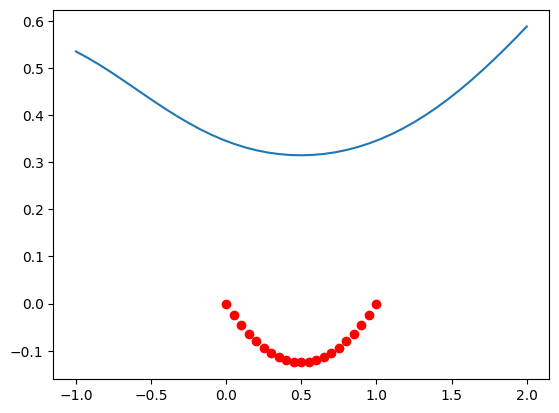

In [22]:
import matplotlib.pyplot as plt
xx = torch.linspace(-1,2,41).reshape(-1,1)
plt.plot(xx.detach(),net(xx).detach())
plt.plot(x.detach(),0.5*(x.detach()**2 - x.detach()),'ro')

## A more challenging case - time-dependent advection-diffusion

Now we seek to solve the equation
$$
\frac{\partial u}{\partial t} + v \frac{\partial u}{\partial x} = \frac{\partial^2 u}{\partial x^2},
$$
which models the transport of a tracer through a medium subject to both advection and diffusion.  This could represent, say, forest fire smoke being emitted from a plume and being transported by wind (advection) and random particle motion (diffusion).

The big difference from the previous example is that the equation is now dependent on two variables, space and time.  As such, our neural network should be parameterized as 
$$
u(x,t) \equiv NN_\theta(x,t) \equiv NN_\theta(X),
$$
where we use big $X$ to represent a vector of both space and time coordinates.


In [39]:
import torch

cuda = torch.device('cuda') 

class PINN(torch.nn.Module):
    def __init__(self,d=2,h=50,n_layers=4):
        super(PINN, self).__init__()    
        self.act = torch.nn.ReLU()
        self.l_1 = torch.nn.Linear(d,h)
        self.h_layers = torch.nn.ModuleList([torch.nn.Linear(h,h) for i in range(n_layers)])
        self.l_f = torch.nn.Linear(h,1)
        
    def forward(self,x):
        
        z = self.act(self.l_1(x))
        for f in self.h_layers:
            z = self.act(f(z)) + z
        return self.l_f(z)
    
    def fwd_reduce(self,x):
        return self.forward(x).sum(1)

net = PINN()
net.cuda()

n_epochs = 500
optimizer = torch.optim.LBFGS(net.parameters(),lr=1.0)

k = 0.1
u0 = 0
u1 = 0

res = 25

x_initial = torch.rand(res,2,requires_grad=True,device=cuda)
x_initial.data[:,1] = 0

u_initial = torch.exp(-((x_initial.detach()[:,0]-0.25)/0.2)**8).reshape(-1,1)# + 0.1*torch.randn_like(x_initial[:,0])

x_left = torch.rand(res,2,requires_grad=True,device=cuda)
x_left.data[:,0] = 0

x_right = torch.rand(res,2,requires_grad=True,device=cuda)
x_right.data[:,0] = 1

x = torch.rand(res**2,2,requires_grad=True,device=cuda)

f = 0#1.0*torch.exp(-((x.detach()[:,0]-0.3)/0.1)**8).reshape(-1,1)
alpha = 1.

v = 0.5

for i in range(n_epochs):
        def closure():
            optimizer.zero_grad()
            
            u_init = net(x_initial)
            u_left = net(x_left)
            u_right = net(x_right)
            u = net(x)
            
            du = torch.autograd.grad(u,x,torch.ones(x.shape[0],1,device=cuda),create_graph=True)[0]
            d2u_x = torch.autograd.grad(du[:,0].reshape(-1,1),x,torch.ones(x.shape[0],1,device=cuda),create_graph=True)[0]
            d2u_t = torch.autograd.grad(du[:,1].reshape(-1,1),x,torch.ones(x.shape[0],1,device=cuda),create_graph=True)[0]
            
            du_left = torch.autograd.grad(u_left,x_left,torch.ones(x_left.shape[0],1,device=cuda),create_graph=True)[0]
            du_right = torch.autograd.grad(u_right,x_right,torch.ones(x_right.shape[0],1,device=cuda),create_graph=True)[0]
            
            I_initial = alpha*torch.mean(torch.abs(u_init - u_initial)**2)
            I_left = torch.mean((u_left - u0)**2)
            I_right = torch.mean((u_right - u1)**2)
            I_u = torch.mean((du[:,1].reshape(-1,1) + v*du[:,0].reshape(-1,1) - k*d2u_x[:,0].reshape(-1,1) - f)**2)
            I = I_u + I_initial + I_left + I_right

            I.backward(retain_graph=True)
            return I  

        I = optimizer.step(closure)
        print(I.item())


0.49761199951171875
0.18847699463367462
0.11245262622833252
0.07291417568922043
0.036173656582832336
0.011604628525674343
0.0063073234632611275
0.0033994726836681366
0.002275775885209441
0.0010130853625014424
0.0006910968804731965
0.0008837227360345423
0.001097880769520998
0.00021503670723177493
0.00017645915795583278
0.00011398195056244731
0.00010172514157602564
9.31911199586466e-05
7.238160469569266e-05
6.52787130093202e-05
5.3246640163706616e-05
5.064392098574899e-05
4.801440809387714e-05
4.56774105259683e-05
4.193128552287817e-05
4.371085742604919e-05
4.1520208469592035e-05
3.9020345866447315e-05
3.3533429814269766e-05
3.201734216418117e-05
2.8683729397016577e-05
2.9748351153102703e-05
3.087894219788723e-05
3.0304508982226253e-05
2.707074054342229e-05
2.737621070991736e-05
2.8174201361252926e-05
2.493855936336331e-05
2.2281818019109778e-05
2.1287256458890624e-05
1.9497598259476945e-05
1.8733295291895047e-05
1.7367499822285026e-05
1.425724258297123e-05
1.3286854482430499e-05
1.27767

KeyboardInterrupt: 

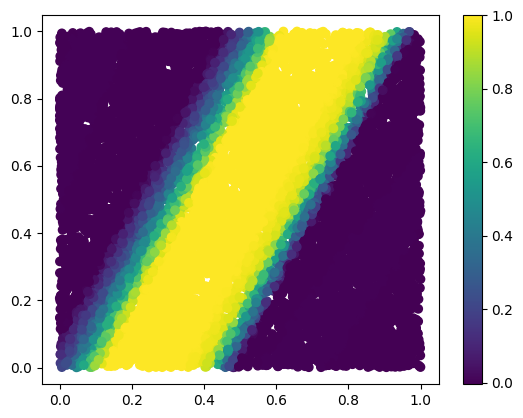

In [40]:
import matplotlib.pyplot as plt
x_total = torch.cat([x,x_initial,x_left,x_right]).cpu()
x_total = torch.rand((10000,2))

x_n = x_total.detach().numpy()
net.cpu()
u_n = net(x_total).detach().numpy()
plt.scatter(x_n[:,0],x_n[:,1],c=u_n)
plt.colorbar()

In [ ]:
import torch
device = torch.device('cuda') 

class AdvDiffPINN(torch.nn.Module):
    def __init__(self,d=2,h=50,n_layers=4):
        super(AdvDiffPINN, self).__init__()    
        self.act = torch.nn.Tanh()
        self.l_1 = torch.nn.Linear(d,h)
        self.h_layers = torch.nn.ModuleList([torch.nn.Linear(h,h) for i in range(n_layers)])
        self.l_f = torch.nn.Linear(h,1)
        
    def forward(self,x):
        
        z = self.act(self.l_1(x))
        for f in self.h_layers:
            z = self.act(f(z)) + z
        return self.l_f(z)

    def get_grad_and_hessian(self,x):
        u = self.forward(x)
        dudx = torch.autograd.grad(u,x,torch.ones(x.shape[0],1,device=device),create_graph=True)[0]
        d2udx2 = torch.autograd.grad(dudx[:,0].reshape(-1,1),x,torch.ones(x.shape[0],1,device=device),create_graph=True)[0]
        d2udt2 = torch.autograd.grad(dudx[:,1].reshape(-1,1),x,torch.ones(x.shape[0],1,device=device),create_graph=True)[0]
        return u,dudx,torch.column_stack((d2udx2[:,0],d2udt2[:,1]))
 
        
    
net = AdvDiffPINN()
net.to(device)

In [ ]:
x = torch.rand(res**2,2,requires_grad=True,device=device)
net.get_grad_and_hessian(x)



In [ ]:
n_epochs = 500
optimizer = torch.optim.LBFGS(net.parameters(),lr=1.0)

k = 0.1
u0 = 0
u1 = 0

res = 100




x_initial = torch.rand(res,2,requires_grad=True,device=cuda)
x_initial.data[:,1] = 0

u_initial = torch.exp(-((x_initial.detach()[:,0]-0.25)/0.2)**8).reshape(-1,1)# + 0.1*torch.randn_like(x_initial[:,0])
